# Sans under-sampling
 Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import NearMiss

from collections import Counter

C:\Users\pault\AppData\Local\Temp\ipykernel_21984\863914600.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [3]:
le = LabelEncoder()

df.rename(columns={"isFraud": "target"}, inplace=True)

df['type_encoded'] = le.fit_transform(df['type'])
df.drop(["type", "nameOrig", "nameDest"], inplace=True, axis=1)
df.head()

,transactionId,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,target,type_encoded
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,3
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0,3
2,2,1,181.00,181.0,0.00,0.0,0.0,1,4
3,3,1,181.00,181.0,0.00,21182.0,0.0,1,1
4,4,1,11668.14,41554.0,29885.86,0.0,0.0,0,3


In [4]:
X, y = df.drop(["target"], axis=1), df["target"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [6]:
y_train

54135     0
468070    0
964436    0
822537    0
258752    0
         ..
246410    0
680585    0
749798    0
742514    0
897124    0
Name: target, Length: 756159, dtype: int64

In [7]:
scoring = make_scorer(balanced_accuracy_score)

grid_parameters_no_sampling = {"n_neighbors" : [1,2,3], "weights" : ["uniform", "distance"]}

knn_no_sampling = GridSearchCV(KNeighborsClassifier(), grid_parameters_no_sampling, scoring=scoring, cv=5, n_jobs=-1)



knn_no_sampling.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'))

In [8]:
print('Best parameters:', knn_no_sampling.best_params_)
print('Best score:', knn_no_sampling.best_score_)

Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Best score: 0.9736184672880214


In [9]:
y_pred_no_sampling = knn_no_sampling.predict(X_test)
cm_no_sampling = confusion_matrix(y_test, y_pred_no_sampling)

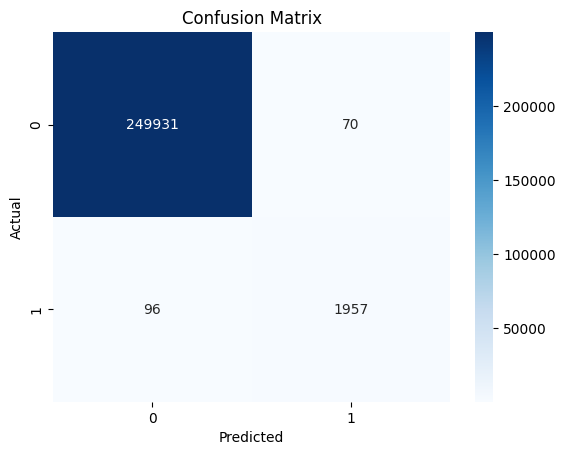

In [10]:
# Create a heatmap using Seaborn
sns.heatmap(cm_no_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

Before: 
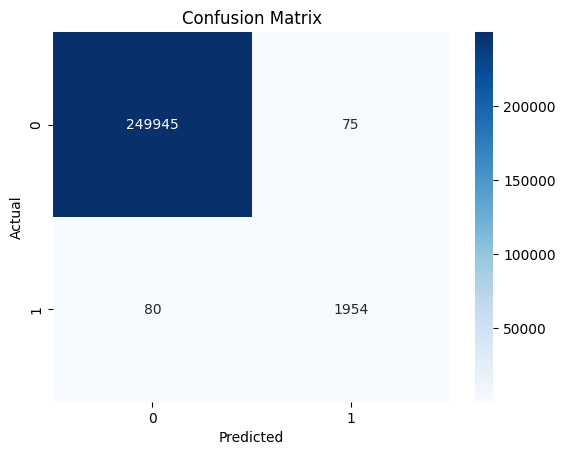


In [11]:
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_no_sampling, pos_label=1)

roc_auc_score(y_test, y_pred_no_sampling)


0.9764795816608257

## Traçage courbe ROC

[Article](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/)

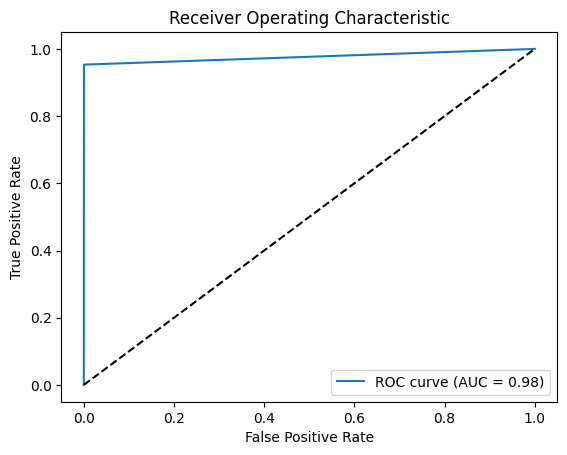

In [12]:
# Assuming y_true contains the true labels and y_pred contains the predicted probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_no_sampling)
auc_score = roc_auc_score(y_test, y_pred_no_sampling)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Avec under_sampling

In [13]:
nm = NearMiss()

x_near_miss, y_near_miss = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_near_miss))

Original dataset shape: Counter({0: 1000000, 1: 8213})
Resample dataset shape: Counter({0: 6160, 1: 6160})


In [14]:
print(x_near_miss.shape)
print(y_near_miss.shape)

(12320, 8)
(12320,)


In [15]:
scoring = make_scorer(accuracy_score)


grid_parameters_with_sampling = {"n_neighbors" : [1,2,3,7,8,9,10], "weights" : ["uniform", "distance"], "algorithm" : ["ball_tree"], "leaf_size" : [1,2,3,4,5]}

knn_under_sampling = GridSearchCV(KNeighborsClassifier(), grid_parameters_with_sampling, scoring=scoring, cv=5, n_jobs=-1)


knn_under_sampling.fit(x_near_miss, y_near_miss)

print('Best parameters:', knn_under_sampling.best_params_)
print('Best score:', knn_under_sampling.best_score_)

Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 10, 'weights': 'uniform'}
Best score: 0.9939123376623377


In [16]:
print('Best parameters:', knn_under_sampling.best_params_)
print('Best score:', knn_under_sampling.best_score_)

Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 10, 'weights': 'uniform'}
Best score: 0.9939123376623377


Premier essai : 
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 7, 'weights': 'uniform'}
Best score: 0.9948212534002849


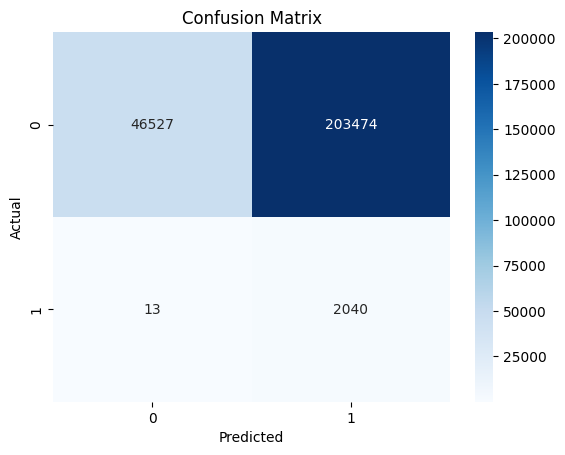

In [17]:
y_pred_under_sampling = knn_under_sampling.predict(X_test)
cm_under_sampling = confusion_matrix(y_test, y_pred_under_sampling)

# Create a heatmap using Seaborn
sns.heatmap(cm_under_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

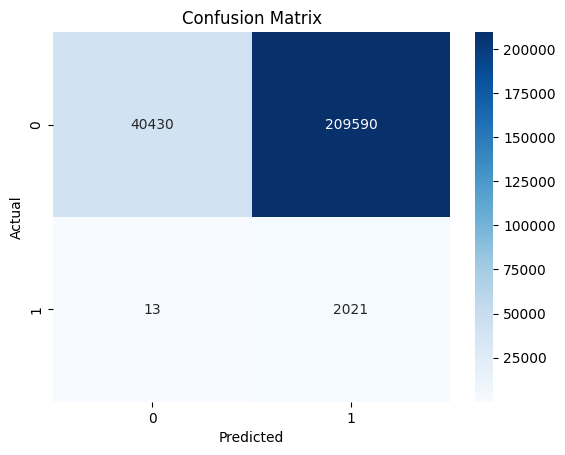

# Avec over sampling

In [18]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, k_neighbors=5)

x_smote, y_smote = sm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smote))

Original dataset shape: Counter({0: 1000000, 1: 8213})
Resample dataset shape: Counter({0: 749999, 1: 749999})


In [19]:
print(x_smote.shape)
print(y_smote.shape)

(1499998, 8)
(1499998,)


In [20]:
scoring = make_scorer(f1_score)


grid_parameters_with_over_sampling = {"n_neighbors" : [3, 5, 7], "leaf_size" : [20]}

knn_over_sampling = GridSearchCV(KNeighborsClassifier(), scoring=scoring, param_grid=grid_parameters_with_over_sampling)


knn_over_sampling.fit(x_smote, y_smote)

print('Best parameters:', knn_over_sampling.best_params_)
print('Best score:', knn_over_sampling.best_score_)

Best parameters: {'leaf_size': 20, 'n_neighbors': 3}
Best score: 0.9970636258004454


### 1er essai
{"n_neighbors" : [1, 3, 5], "leaf_size" : [20, 30, 40]}
Durée : 21m
Best parameters: {'leaf_size': 20, 'n_neighbors': 1}
Best score: 0.9980419006682828

### 2ème essai
{"n_neighbors" : [3, 5, 7], "leaf_size" : [20]}
Durée : 9m
Best parameters: {'leaf_size': 20, 'n_neighbors': 3}
Best score: 0.9972584216188954




In [21]:
print('Best parameters:', knn_over_sampling.best_params_)
print('Best score:', knn_over_sampling.best_score_)

Best parameters: {'leaf_size': 20, 'n_neighbors': 3}
Best score: 0.9970636258004454


Premier essai : 
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 7, 'weights': 'uniform'}
Best score: 0.9948212534002849


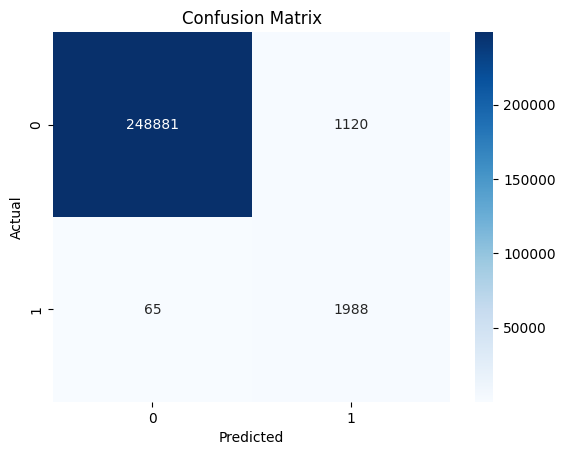

In [22]:
y_pred_over_sampling = knn_over_sampling.predict(X_test)
cm_over_sampling = confusion_matrix(y_test, y_pred_over_sampling)

# Create a heatmap using Seaborn
sns.heatmap(cm_over_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

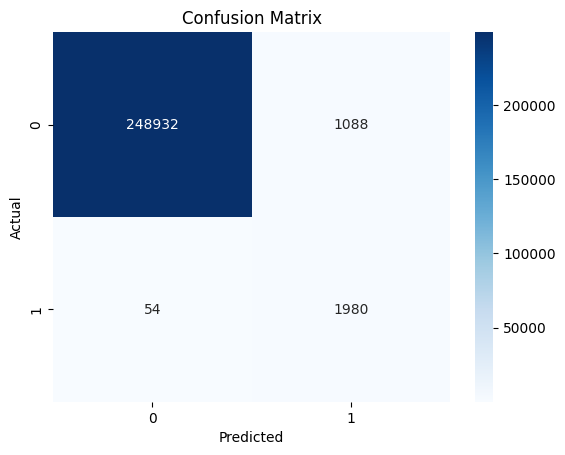


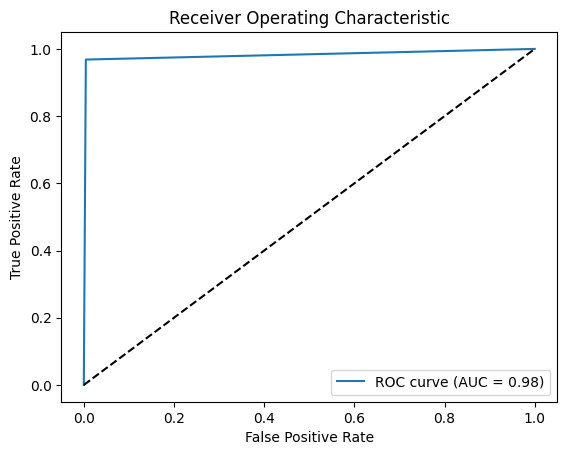

In [23]:
# Assuming y_true contains the true labels and y_pred contains the predicted probabilities for the positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_over_sampling)
auc_score = roc_auc_score(y_test, y_pred_over_sampling)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Essai TPOT